In [62]:
import pandas as pd
import numpy as np
import load_data
from datetime import date

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# на сайте доступны данные только с июня 2018-го
try:
    fact_data = pd.read_csv('fact_data.csv', parse_dates=['date'])
except OSError:
    r = load_data.RegionFactReport()
    fact_data = r.download(date(2018, 6, 1), date(2018, 10, 1))
    fact_data.to_csv('fact_data.csv', index=False)

In [3]:
try:
    pred_data = pd.read_csv('pred_data.csv', parse_dates=['date'])
except OSError:
    r = load_data.SOForecastConsumSubReport()
    pred_data = r.download(date(2018, 6, 1), date(2018, 10, 31))
    pred_data.to_csv('pred_data.csv', index=False)

In [4]:
fact_data = pd.merge(
    fact_data,
    pred_data,
    how='left',
    on=['date', 'hour', 'region_id']
)

In [5]:
fact_data.dropna(inplace=True)
fact_data.sort_values(by=['region_id', 'date', 'hour'], inplace=True)

<IPython.core.display.Javascript object>


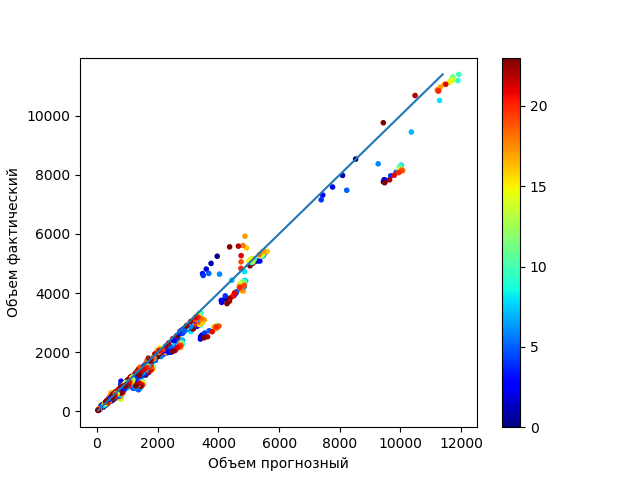

In [63]:
a = fact_data[fact_data.date == fact_data.date.min()]
plt.scatter(a.vol_con_plan, a.fact, c=a.hour, cmap=plt.get_cmap('jet'), marker='.')
plt.plot([a.fact.min(), a.fact.max()], [a.fact.min(), a.fact.max()])
plt.colorbar();
plt.xlabel('Объем прогнозный')
plt.ylabel('Объем фактический')
plt.savefig('pic/fact_vol1.png', transparent=True)

# Временные ряды. ARIMA

In [27]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

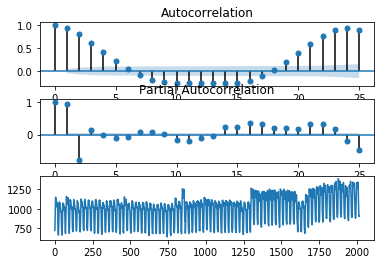

In [42]:
test_sample = fact_data.loc[fact_data.region_id == fact_data.region_id.min(), 'fact'].values
fig = plt.figure()
ax1 = fig.add_subplot(311)
fig = sm.graphics.tsa.plot_acf(test_sample, lags=25, ax=ax1)
ax2 = fig.add_subplot(312)
fig = sm.graphics.tsa.plot_pacf(test_sample, lags=25, ax=ax2)
ax3 = fig.add_subplot(313)
ax3.plot(test_sample);

In [64]:
arima_model = ARIMA(test_sample[:-24], (10, 1, 3)).fit()
predict, _, _ = arima_model.forecast(24)

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<IPython.core.display.Javascript object>


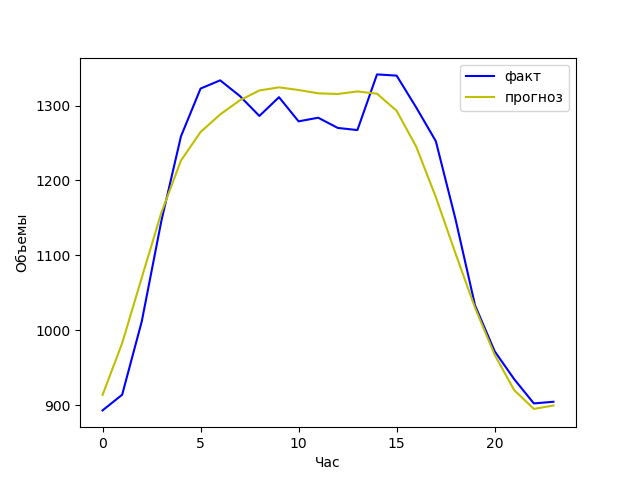

In [65]:
plt.plot(test_sample[-24:], c='b', label='факт')
plt.plot(predict, c='y', label='прогноз');
plt.xlabel('Час')
plt.ylabel('Объемы')
plt.legend()
plt.savefig('pic/fact_vol2.png', transparent=True)

# Нейронные сети

In [7]:
from sklearn.neural_network import MLPRegressor

In [66]:
mlp_model = MLPRegressor(
    hidden_layer_sizes = (200, ),
    solver='adam'
)

In [67]:
region_data = fact_data.set_index(['date', 'hour', 'region_id']).fact.unstack('region_id').values.T

In [175]:
train_len = 24 * 7 * 4
predict_len = 24
batch_len = 64

def train(N, model, data):
    max_i = data.shape[0]
    max_j = data.shape[1] - (predict_len + train_len) - 24
    
    for _ in range(N):
        x_batch = []
        y_batch = []
        for _ in range(batch_len):
            i = np.random.randint(max_i)
            j = np.random.randint(max_j)
            x_batch.append(data[i, j:j+train_len])
            y_batch.append(data[i, j+train_len: j+train_len+predict_len])
        x_batch = np.vstack(x_batch)
        y_batch = np.vstack(y_batch)

        model.partial_fit(x_batch, y_batch)

In [69]:
train(100, mlp_model, region_data)
predict = mlp_model.predict(test_sample[-24-train_len:-24].reshape(1, -1))[0]

100 шагов обучения

<IPython.core.display.Javascript object>


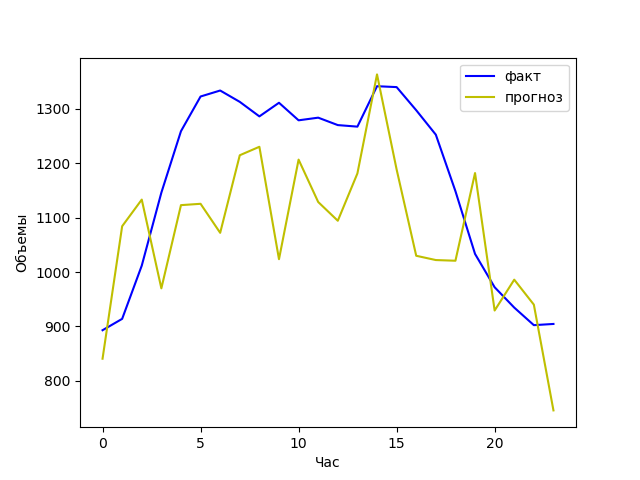

In [72]:
plt.plot(test_sample[-24:], c='b', label='факт')
plt.plot(predict, c='y', label='прогноз');
plt.xlabel('Час')
plt.ylabel('Объемы')
plt.legend()
plt.savefig('pic/fact_vol3_1.png', transparent=True)

спустя еще 1000 шагов обучения

In [73]:
train(1000, mlp_model, region_data)
predict = mlp_model.predict(test_sample[-24-train_len:-24].reshape(1, -1))[0]

<IPython.core.display.Javascript object>


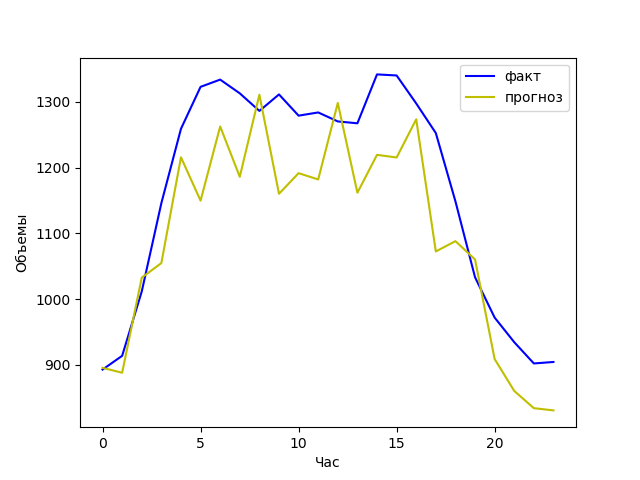

In [74]:
plt.plot(test_sample[-24:], c='b', label='факт')
plt.plot(predict, c='y', label='прогноз');
plt.xlabel('Час')
plt.ylabel('Объемы')
plt.legend()
plt.savefig('pic/fact_vol3_2.png', transparent=True)

спустя ещё 10000 шагов обучения

In [75]:
train(10000, mlp_model, region_data)
predict = mlp_model.predict(test_sample[-24-train_len:-24].reshape(1, -1))[0]

<IPython.core.display.Javascript object>


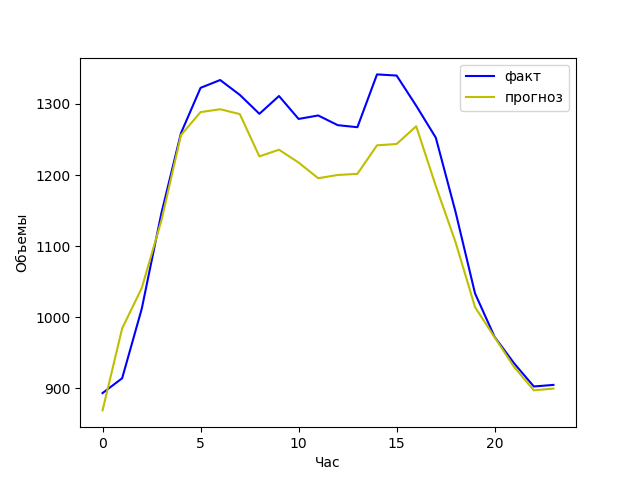

In [76]:
plt.plot(test_sample[-24:], c='b', label='факт')
plt.plot(predict, c='y', label='прогноз');
plt.xlabel('Час')
plt.ylabel('Объемы')
plt.legend()
plt.savefig('pic/fact_vol3_3.png', transparent=True)

In [185]:
def train(N, model, data):
    max_i = data.shape[0]
    max_j = data.shape[1] - (predict_len + train_len) - 24
    
    for _ in range(N):
        x_batch = []
        y_batch = []
        for _ in range(batch_len):
            i = np.random.randint(max_i)
            j = np.random.randint(max_j)
            x = data[i, j:j+train_len]
            x_batch.append(np.hstack((
                x,
                x.mean(),
                x[-train_len//2:].mean(),
                x[-train_len//4:].mean(),
                x[-24:].mean(),
                x[-train_len//4:].std(),
                x[-24:].std()
            )))
            y_batch.append(data[i, j+train_len: j+train_len+predict_len])
        x_batch = np.vstack(x_batch)
        y_batch = np.vstack(y_batch)

        model.partial_fit(x_batch, y_batch)

In [197]:
mlp_model = MLPRegressor(
    hidden_layer_sizes = (300, 100, 50),
    solver='adam',
)

In [198]:
train(50000, mlp_model, region_data)

In [252]:
x = region_data[50, -24-train_len:-24]
x = np.hstack((
    x,
    x.mean(),
    x[-train_len//2:].mean(),
    x[-train_len//4:].mean(),
    x[-24:].mean(),
    x[-train_len//4:].std(),
    x[-24:].std()
))
predict = mlp_model.predict(x.reshape(1, -1))[0]

<IPython.core.display.Javascript object>


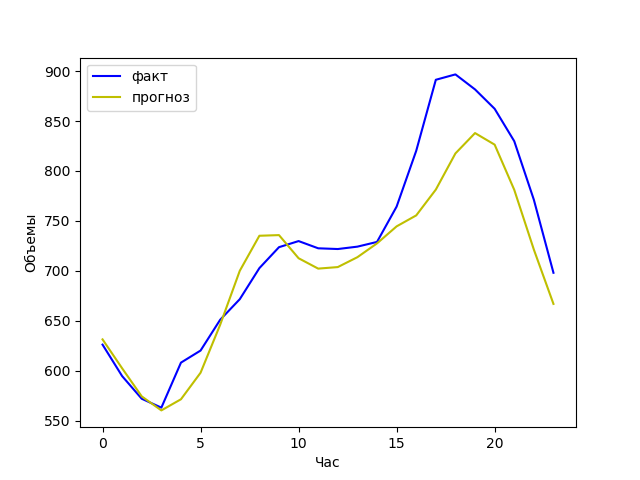

In [253]:
plt.plot(region_data[50,-24:], c='b', label='факт')
plt.plot(predict, c='y', label='прогноз');
plt.xlabel('Час')
plt.ylabel('Объемы')
plt.legend()
plt.savefig('pic/fact_vol3_8.png', transparent=True)